# Warhammer calculations

In [1]:
from __future__ import absolute_import, division, print_function
from builtins import *
import scipy.stats as stats
import scipy.misc as scm
import matplotlib.pyplot as plt
import random
from itertools import product
%matplotlib inline

## Function defines

In [2]:
def successes(tries, prob):
    return {x: stats.binom.pmf(x, tries, prob) for x in range(tries+1)}

In [3]:
def compound_successes(profile, prob):
    return {x: sum(stats.binom.pmf(x, y, prob) * profile[y] for y in profile if y >= x) for x in profile}

In [4]:
def chances_from_dice(target_val, n, faces):
    return (1 / faces ** n) * sum(((-1) ** i) * scm.comb(n, i) * scm.comb(target_val - faces * i - 1, n - 1) 
                                  for i in range((target_val - n) // faces + 1))

In [40]:
def assign_damage(profile, damage_list, target, specials=None):
    random.seed()
    n = len(set(damage_list))
    output = {0: profile[0] * 100}
    if n == 1:    
        for h in profile:
            
            if h == 0 or profile[h] < 0.001: continue
            
            if h * damage_list[0] <= target['total']:
                output[h * damage_list[0]] = profile[h] * 100
            else:
                output[target['total']] += profile[h] * 100
        return output        

    for h in profile:
        
        if h == 0 or profile[h] < 0.001: continue

        for i in range(4000):
            throw = []
            
            for j in range(h):
                if specials and 'multi-melta' in specials:
                    throw.append(max(random.choice(damage_list), random.choice(damage_list)))
                else: 
                    throw.append(random.choice(damage_list))
            
            spare_wounds = target['wounds']
            
            for dice in throw:
                if dice >= spare_wounds: 
                    dice = spare_wounds
                    spare_wounds = target['wounds']
                else:
                    spare_wounds = spare_wounds - dice
             
            result = min(sum(throw), target['total'])

            if result in output: 
                output[result] += 0.025 * profile[h]
            else:
                output[result] = 0.025 * profile[h]
            
    return output    

In [24]:
def damage_dealt(profile, target):
    damage_list = [min(x, target['wounds']) for x in damage_types[profile['damage']]]
    
    if isinstance(profile['shots'], int):
        hits = successes(profile['shots'], profile['p_hit']) 
    else: 
        if ('specials' in profile) and ('demolisher' in profile['specials']) and (target['total'] / target['wounds'] > 5):
            profile['shots'] = 'd6'

        hits = compound_successes(hits_profiles(profile['shots']) , profile['p_hit'])
            
    
    wounds = compound_successes(hits, wound_chance(profile['S'], target['T']))
    
    unsaved = compound_successes(wounds, min(min(1 - target['save'] - profile.get('AP', 0) / 6, 1), 1 - target.get('invul', 0)))
    
    if 'FNP' in target:
        unsaved = compound_successes(unsaved, 1 - target['FNP'])
    
    return assign_damage(unsaved, damage_list, target, profile.get('specials', None))

In [7]:
def wound_chance(S, T):
    if S == T:
        return 1 / 2
    elif S >= 2 * T:
        return 5 / 6
    elif S > T:
        return 2 / 3
    elif 2 * S <= T:
        return 1 / 6
    else:
        return 1 / 3

In [8]:
def wound_chart(profiles, targets, titles=None):
    titles = product(*titles) if titles else 0
    
    if len(profiles) * len(targets) == 1:
            
            xs = damage_dealt(profiles[0], targets[0]).keys()
            ys = damage_dealt(profiles[0], targets[0]).values()
            
            plt.bar(xs, ys, color = 'forestgreen', edgecolor= 'darkgreen', width = 1, align = 'center')
            plt.axis('tight')
            plt.set_xlabel('Wounds')
            plt.set_ylabel('Probability, %')
            
            if titles:
                plt.title('{1} vs {0}'.format(*titles.next()), fontweight = 'bold')
            else:
                plt.title('{shots} shots, {damage} damage, p_hit: {p_hit:.0%}, S: {S}'.format(**profiles[0]))
            
            plt.figure(1).text(0.95, 0.81, 'Expected: {:.1f} wounds'.format(sum(x * y / 100 for x, y in zip(xs, ys))),
                              fontsize = 12, fontweight = 'bold')
            plt.figure(1).text(0.95, 0.68, 'Target profile', fontsize = 12, fontweight = 'bold')
            plt.figure(1).text(0.95, 0.64, '\n'.join(['{}: {:.2g}'.format(key, value) for key, value in targets[0].items()]),
                               verticalalignment='top', fontsize = 12)
            plt.show()
            return None
    
    num_rows = (len(profiles) * len(targets) + 1) // 2
    
    f, axarr = plt.subplots(num_rows, 2, figsize=(13.5, 4 * num_rows), sharey=True, sharex=True)
    
    plt.subplots_adjust(wspace=0.76)
    
    counter = 0
    xbound = [0, 0]
    
    for target in targets:
        for profile in profiles:
            frame = axarr[counter] if num_rows == 1 else axarr[counter // 2, counter % 2]
            
            (xs, ys) = zip(*damage_dealt(profile, target).iteritems())
            
            xbound = [min(xbound[0], min(xs)), max(xbound[1], max(xs))]
            frame.set_xlim(xbound[0] - 0.5, xbound[1] + 0.5)
            frame.bar(xs, ys, color = 'forestgreen', edgecolor= 'darkgreen', width = 1, align = 'center')
            frame.set_xlabel('Wounds')
            frame.set_ylabel('Probability, %')
            
            if titles:
                frame.set_title('{1} vs {0}'.format(*titles.next()), fontweight = 'bold')
            else:
                frame.set_title('{shots} shots, {damage} damage, p_hit: {p_hit:.0%}, S: {S}'.format(**profile), fontweight = 'bold')
            
            frame.text(1.05, 0.81, 'Expected: {:.1f} wounds'.format(sum(x * y / 100 for x, y in zip(xs, ys))),
                              fontsize = 12, fontweight = 'bold', transform = frame.transAxes)
            frame.text(1.05, 0.64, '\n'.join(['{}: {:.2g}'.format(key, value) for key, value in target.items()]),
                               verticalalignment='top', fontsize = 12, transform = frame.transAxes)
            frame.text(1.05, 0.68, 'Target profile', fontsize = 12, fontweight = 'bold', transform = frame.transAxes)
            
            counter += 1
    plt.show()
    return None

## Variable input

In [45]:
damage_types = {'1': [1], '2': [2], '3': [3], '4': [4], 'd3': [1, 2, 3], 'd6': [1, 2, 3, 4, 5, 6]}
hits_profiles = lambda code: {x: chances_from_dice(x, int(code[0]), int(code[-1])) for x in range(0, int(code[0])*int(code[-1]))}

profiles = [{'shots': '3d6', 'p_hit':  1, 'S': 6, 'damage': '2', 'AP': -1},
            {'shots': 6, 'p_hit': 1 / 2 + 1 / 6 * 1 / 2, 'S': 7, 'damage': '2', 'AP': -1}]

targets = [{'T': 6, 'wounds': 10, 'total': 10, 'save': 1 / 2, 'invul': 1 / 3},
           {'T': 5, 'wounds': 10, 'total': 10, 'save': 1 / 2, 'invul': 1 / 3},
           {'T': 3, 'wounds': 1, 'total': 10, 'save': 1 / 6, 'invul': 1 / 2, 'FNP': 1 / 6}]

## Work

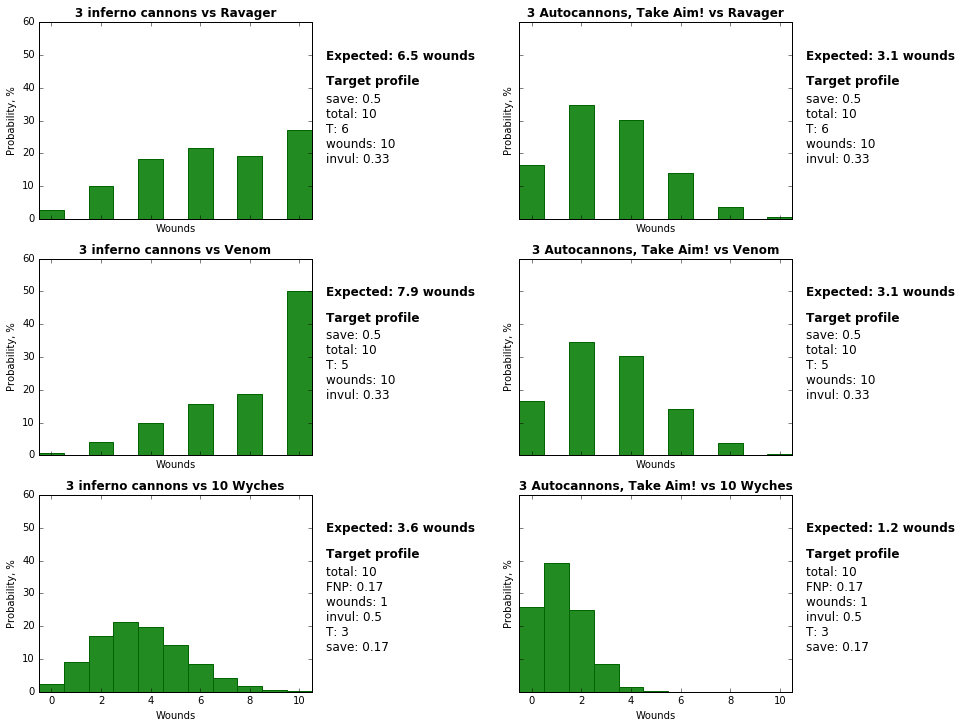

In [46]:
wound_chart(profiles, targets, [['Ravager', 'Venom', '10 Wyches'], ['3 inferno cannons', '3 Autocannons, Take Aim!']])